In [78]:
# from easyesn import BaseESN
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os
from IPython.display import clear_output
import time
from tabulate import tabulate
from sklearn import preprocessing, linear_model
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from scipy.special import expit
from scipy.optimize import curve_fit
import winsound
duration = 3000
freq = 400

In [30]:
def update_x(x, sigma, r, b, dt):
    tmp_x1 = sigma*(-x[0] + x[1])
    tmp_x2 = -x[0]*x[2] + r*x[0] - x[1]
    tmp_x3 = x[0]*x[1] - b*x[2]
    tmp_x = np.array([tmp_x1, tmp_x2, tmp_x3])
    return np.add(x, dt*tmp_x)

def generate_data(sigma, r, b, dt, T, n_paths):
    t_list = np.linspace(0, T, int(T/dt+1))
    idx = list(range(len(t_list)))
    
    x1 = np.zeros([n_paths, len(t_list)])
    x2 = np.zeros([n_paths, len(t_list)])
    x3 = np.zeros([n_paths, len(t_list)])
    for n in range(n_paths):
        x = -1 + 2*np.random.rand(3)
        for iT in range(len(t_list)):
            x1[n,iT] = x[0]
            x2[n,iT] = x[1]
            x3[n,iT] = x[2]
            x = update_x(x, sigma, r, b, dt)
        clear_output(wait=True)
        print(str(100 * (n+1)/n_paths) + '% done')
        
    return t_list, x1, x2, x3

def plot_simulation(x1, x2, x3, path_choice):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot(x1[path_choice,:], x2[path_choice,:], x3[path_choice,:])
            

#### Generate Data, throw away transient

100.0% done


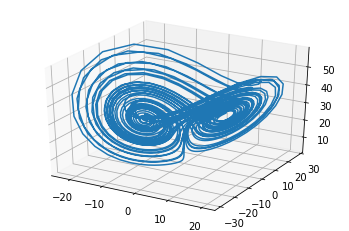

In [38]:
sigma = 10
r = 28
b = 8/3
dt = .02
T = 53
n_paths = 500
t_list, x1, x2, x3 = generate_data(sigma, r, b, dt, T, n_paths)
transient = int(3 / dt)
x1 = x1[:,transient:]
x2 = x2[:,transient:]
x3 = x3[:,transient:]
plot_simulation(x1, x2, x3, 0)

#### Split into train, test

In [39]:
first_split = int(x1.shape[1] * .7)

TR_indexes = range(first_split)
TS_indexes = range(first_split, int(x1.shape[1]))

print('len(train) = ' + str(len(TR_indexes)))
print('len(test) = ' + str(len(TS_indexes)))
print('with ' + str(n_paths) + ' paths')

len(train) = 1750
len(test) = 751
with 500 paths


#### Examine Data

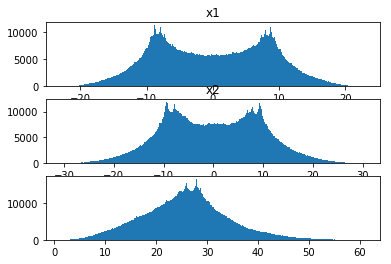

Axis      Minimum        Mean    Variance    Maximum
------  ---------  ----------  ----------  ---------
x1      -22.9322   -0.0514338     71.5243    22.9835
x2      -30.6559   -0.0520013     93.2933    30.5136
x3        1.28518  25.816         69.5559    61.0389


In [40]:
fig, axs = plt.subplots(3)
axs[0].hist(x1.flatten(),bins=300)
axs[0].set_title('x1')
axs[1].hist(x2.flatten(),bins=300)
axs[1].set_title('x2')
axs[2].hist(x3.flatten(),bins=300)
plt.show()

print(
    tabulate(
        [['x1', x1.min(), x1.mean(), x1.var(), x1.max()],
         ['x2', x2.min(), x2.mean(), x2.var(), x2.max()],
         ['x3', x3.min(), x3.mean(), x3.var(), x3.max()]],
        headers=['Axis', 'Minimum', 'Mean', 'Variance', 'Maximum']
    )
)

#### Scale Data

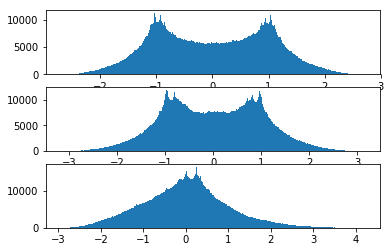

Axis      Minimum          Mean    Variance    Maximum
------  ---------  ------------  ----------  ---------
x1       -2.70547   1.24778e-17           1    2.7237
x2       -3.16848   2.81149e-17           1    3.16451
x3       -2.94134  -1.6203e-16            1    4.22337


In [41]:
scaler_x1 = StandardScaler(with_mean=True, with_std=True).fit(x1.reshape(-1,1))
scaler_x2 = StandardScaler(with_mean=True, with_std=True).fit(x2.reshape(-1,1))
scaler_x3 = StandardScaler(with_mean=True, with_std=True).fit(x3.reshape(-1,1))
x1 = scaler_x1.transform(x1)
x2 = scaler_x2.transform(x2)
x3 = scaler_x3.transform(x3)

fig, axs = plt.subplots(3)
axs[0].hist(x1.flatten(),bins=300)
axs[1].hist(x2.flatten(),bins=300)
axs[2].hist(x3.flatten(),bins=300)
plt.show()

print(
    tabulate(
        [['x1', x1.min(), x1.mean(), x1.var(), x1.max()],
         ['x2', x2.min(), x2.mean(), x2.var(), x2.max()],
         ['x3', x3.min(), x3.mean(), x3.var(), x3.max()]],
        headers=['Axis', 'Minimum', 'Mean', 'Variance', 'Maximum']
    )
)

In [42]:
def generate_weight_matrix(n_inputs, n_outputs, density, connectivity, scheme, M=0):
    n = n_inputs * n_outputs
    if connectivity == 'close':
        r = -1 + 2 * np.random.rand(n_inputs, n_outputs)
    elif connectivity == 'larger':
        r = -5 + 10 * np.random.rand(n_inputs, n_outputs)
    elif connectivity == 'smaller':
        r = -.5 + np.random.rand(n_inputs, n_outputs)
    else:
        sys.exit('Invalid connectivity parameter')

    if scheme == 'uniform':
        W = np.random.rand(n_inputs, n_outputs) < density
    elif scheme == 'erdos-renyi':
        if M == 0:
            M = np.random.randint(1, n)
        W = np.zeros((n_inputs, n_outputs))
        for i in range(M):
            not_done = True
            while not_done:
                i = np.random.randint(1, n_inputs)
                j = np.random.randint(1, n_outputs)
                if W[i,j] == 0:
                    W[i,j] = 1
                    not_done = False
    else:
        sys.exit('Invalid scheme parameter')

    return np.multiply(W, r)

class layer:        
    def __init__(self, n_reservoir, n_inputs, n_outputs, density, input_density, 
                 connectivity, scheme, is_first_layer=False, leaky_rate=None, M=0):
#         if is_first_layer:
#             self.Win = -.1 + .2*np.random.rand(n_inputs,n_reservoir)
#         else:
#             self.Win = generate_weight_matrix(n_inputs, n_reservoir, input_density, connectivity, scheme, M)
        self.Win = -.1 + .2*np.random.rand(n_inputs,n_reservoir)
        self.W = generate_weight_matrix(n_reservoir, n_reservoir, density, connectivity, scheme, M)
        scale = 1/self.W.max()
        self.W = self.W / scale

        self.x = np.expand_dims(np.zeros(n_reservoir), 1)
        self.a = leaky_rate
        self.D = []
        
#     def get_Dii(self):
#         return 1 / np.cosh(self.x)**2
    
#     def calculate_J(self):
#         J = np.diag(self.D[0].flatten()) * self.W
#         for t in range(len(self.D)):
#             J = J * np.diag(self.D[0].flatten()) * self.W
#             clear_output(wait=True)
#             print(str(100*t/len(self.D)) + '% done')
#         return J
            
    def update(self, u):
        recursive_influence = np.dot(self.W, self.x)
        if len(u.shape) == 1:
            inward_influence = np.dot(self.Win.T, np.expand_dims(u,1))
        else:
            inward_influence = np.dot(self.Win.T, u)
        if not self.a is None:
            recursive_influence = self.a * recursive_influence
            inward_influence = (1 - self.a) * inward_influence
            
        self.x = np.tanh(recursive_influence + inward_influence)
#         self.D.append(self.get_Dii())

#### Set up network
Using tanh() activation function and no biases

In [43]:
n_reservoir = 1000
n_inputs = 3
n_outputs = 3
n_layers = 2
density = .01
input_density = 1
leaky_rate = .15
connectivity = 'close'
scheme = 'uniform'
M = 50

layers_save = []
for i_layer in range(n_layers):
    if i_layer == 0:
        layers_save.append(layer(n_reservoir, n_inputs, n_reservoir, density, input_density, connectivity, scheme, True, leaky_rate, M))
    elif i_layer == n_layers-1:
        layers_save.append(layer(n_reservoir, n_reservoir, n_outputs, density, input_density, connectivity, scheme, False, leaky_rate, M))
    else:
        layers_save.append(layer(n_reservoir, n_reservoir, n_reservoir, density, input_density, connectivity, scheme, False, leaky_rate, M))

#### Get reservoir output for training data

500 of 500 completed


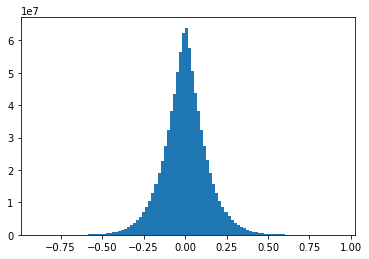

In [44]:
X = np.zeros((n_paths, len(TR_indexes), n_reservoir))  # final reservoir's state
for n in range(n_paths):
    layers = layers_save
    for t in TR_indexes:
        u = np.array([x1[n,t], x2[n,t], x3[n,t]])      # input into the first reservoir
        layers[0].update(u)
        for i_layer in range(1,n_layers):
            layers[i_layer].update(layers[i_layer-1].x)
        X[n,t] = np.squeeze(layers[n_layers-1].x)
        
    clear_output(wait=True)
    print(str(n+1) + ' of ' + str(n_paths) + ' completed')
plt.hist(X.flatten(),bins=100)
plt.show()

#### Train output weights
Using least squares

In [45]:
tmp_X = X[:,transient:].reshape((-1, n_reservoir))
t_list = np.arange(transient+1, len(TR_indexes)+1)

tmp_Y1 = np.array(x1[:, t_list]).reshape(-1, 1)
tmp_Y2 = np.array(x2[:, t_list]).reshape(-1, 1)
tmp_Y3 = np.array(x3[:, t_list]).reshape(-1, 1)

model1 = LinearRegression().fit(tmp_X, tmp_Y1)
print('x_1 done')
model2 = LinearRegression().fit(tmp_X, tmp_Y2)
print('x_2 done')
model3 = LinearRegression().fit(tmp_X, tmp_Y3)
print('x_3 done')

model1MSE = np.mean((model1.predict(tmp_X) - tmp_Y1)**2)
model2MSE = np.mean((model2.predict(tmp_X) - tmp_Y2)**2)
model3MSE = np.mean((model3.predict(tmp_X) - tmp_Y3)**2)

clear_output(wait=True)
print(
    tabulate(
        [['x1', model1.score(tmp_X, tmp_Y1), model1MSE],
         ['x2', model2.score(tmp_X, tmp_Y2), model2MSE],
         ['x3', model3.score(tmp_X, tmp_Y3), model3MSE]],
        headers=['Axis', 'R^2', 'MSE']
    )
)

# Wout = np.array([model1.coef_, model2.coef_, model3.coef_]).squeeze().T

Axis      R^2          MSE
------  -----  -----------
x1          1  3.48764e-27
x2          1  1.85746e-24
x3          1  2.81893e-24


#### Test Model

In [46]:
Y = np.zeros((n_paths, len(TS_indexes), n_reservoir))        # final reservoir's state
O = np.zeros((n_paths, len(TS_indexes)-1, n_outputs))        # output
targets = np.zeros((n_paths, len(TS_indexes)-1, n_outputs))
start = TS_indexes[0]

for n in range(n_paths):
    u = np.array([x1[n, start], x2[n, start], x3[n, start]])    # input into the first reseroir
    layers = layers_save
    for t in range(len(TS_indexes)-1):
        layers[0].update(u)
        for i_layer in range(1, n_layers):
            layers[i_layer].update(layers[i_layer-1].x)
        
        Y[n,t] = np.squeeze(layers[n_layers-1].x)
        targets[n,t] = np.squeeze(np.array([x1[n, t+start+1], x2[n, t+start+1], x3[n, t+start+1]]))
        if t > transient:
            pred_x1 = model1.predict(np.expand_dims(Y[n, t], 1).T)
            pred_x2 = model2.predict(np.expand_dims(Y[n, t], 1).T)
            pred_x3 = model3.predict(np.expand_dims(Y[n, t], 1).T)
            O[n,t] = np.squeeze(np.array([pred_x1, pred_x2, pred_x3]))
            u = O[n,t]
        else:
            u = targets[n,t]
            O[n,t] = u
    clear_output(wait=True)
    print(str(n+1) + ' of ' + str(n_paths) + ' completed')

500 of 500 completed


### MSE as a function of $\lambda_1 = 0.90355$

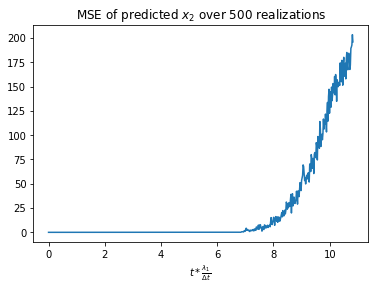

NameError: name 'frequency' is not defined

In [92]:
x2_errors = np.mean((O - targets)**2,axis=0)[:,1]
lyapunov_time = 0.90355
t_list = np.arange((len(x2_errors) - transient)*dt, step=dt) * lyapunov_time

plt.plot(t_list,x2_errors[transient:])
plt.title(r'MSE of predicted $x_2$ over ' + str(n_paths) + ' realizations')
# plt.yscale('log')
plt.xlabel(r'$t * \frac{\lambda_1} {\Delta t}$')
plt.show()
winsound.Beep(frequency, duration)

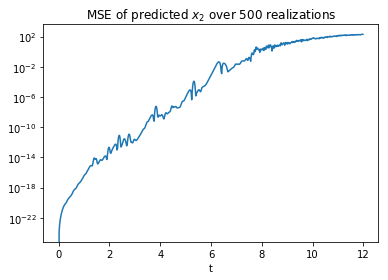

In [88]:
x2_errors = np.mean((O - targets)**2,axis=0)[:,1]
lyapunov_time = 1
t_list = np.arange((len(x2_errors) - transient)*dt, step=dt) * lyapunov_time

plt.plot(t_list,x2_errors[transient:])
plt.title(r'MSE of predicted $x_2$ over ' + str(n_paths) + ' realizations')
plt.yscale('log')
plt.xlabel('t')
plt.show()

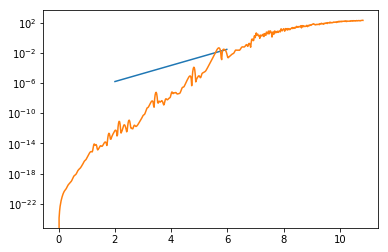

In [128]:
# np.where(t_list>2)
x = t_list[111:332]
y = x2_errors[transient+111:transient+332]
p = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y, p0=[1, .90335])
y_plot = p[0][0] * np.exp(p[0][1]*x)
plt.plot(x,y_plot)
plt.plot(t_list,x2_errors[transient:])
plt.yscale('log')

In [129]:
[t_list, x2_errors]

[array([ 0.      ,  0.018071,  0.036142,  0.054213,  0.072284,  0.090355,
         0.108426,  0.126497,  0.144568,  0.162639,  0.18071 ,  0.198781,
         0.216852,  0.234923,  0.252994,  0.271065,  0.289136,  0.307207,
         0.325278,  0.343349,  0.36142 ,  0.379491,  0.397562,  0.415633,
         0.433704,  0.451775,  0.469846,  0.487917,  0.505988,  0.524059,
         0.54213 ,  0.560201,  0.578272,  0.596343,  0.614414,  0.632485,
         0.650556,  0.668627,  0.686698,  0.704769,  0.72284 ,  0.740911,
         0.758982,  0.777053,  0.795124,  0.813195,  0.831266,  0.849337,
         0.867408,  0.885479,  0.90355 ,  0.921621,  0.939692,  0.957763,
         0.975834,  0.993905,  1.011976,  1.030047,  1.048118,  1.066189,
         1.08426 ,  1.102331,  1.120402,  1.138473,  1.156544,  1.174615,
         1.192686,  1.210757,  1.228828,  1.246899,  1.26497 ,  1.283041,
         1.301112,  1.319183,  1.337254,  1.355325,  1.373396,  1.391467,
         1.409538,  1.427609,  1.44568

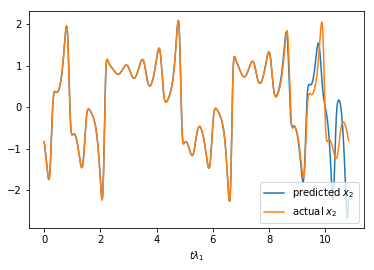

In [141]:
num_lyaps_to_plot = 15
traj_choice = 1
num_data_points = len(np.where(t_list < num_lyaps_to_plot)[0])

plt.plot(t_list[:num_data_points], O[traj_choice ,transient:transient+num_data_points, 1], label=r'predicted $x_2$')
plt.plot(t_list[:num_data_points], targets[traj_choice, transient:transient+num_data_points, 1], label=r'actual $x_2$')
plt.legend()
plt.xlabel(r'$t \lambda_1$')
plt.show()

In [1]:
print('Predicted Run')
plot_simulation(O[:,transient:transient+num_data_points,0], 
                O[:,transient:transient+num_data_points,1], 
                O[:,transient:transient+num_data_points,2], 0)

Predicted Run


NameError: name 'plot_simulation' is not defined

In [2]:
print('Actual Run')
start = TS_indexes[0] + transient
plot_simulation(x1[:,start:start+num_data_points], 
                x2[:,start:start+num_data_points], 
                x3[:,start:start+num_data_points],0)

Actual Run


NameError: name 'TS_indexes' is not defined